## Transfer EPLus Medium Office Building to SEB state transition matrix

In [1]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

In [54]:
#always forget to do this for better looking plots
import seaborn
seaborn.set()

import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
#from cvxpy import *
from statsmodels.tsa import stattools
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import random
import copy
import scipy
import pickle
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#energyplus processing functions
from eplusprocessing import *
from buildsys_funcs import *

In [45]:
class nnet(nn.Module):
    #linear model for kernelized inputs
    def __init__(self, params):
        super(nnet, self).__init__()
        self.D_in = params['FEATURE_DIM']
        self.D_HIDDEN = params['HIDDEN_DIM']
        self.D_out = params['OUTPUT_DIM']
        self.l1 = nn.Linear(self.D_in, self.D_HIDDEN)
        self.l2 = nn.Linear(self.D_HIDDEN, self.D_out)
    
    def forward(self, x):
        x = F.sigmoid(self.l1(x)) 
        x = self.l2(x)
        return(x)

## SEB Data

In [3]:
#SEB helper functions

def read_file_timestamp(strin):
    out = datetime.datetime.strptime(strin, '%Y-%m-%dT%H:%M:%S')
    return(out)

def file_name_from_timestamp(dtobj):
    out = datetime.datetime.strftime(dtobj, "%Y-%m-%d")
    return(out)

def read_volttron_file(fobj, col=1):
    p = []
    lines = fobj.readlines()
    lines.pop(0)
    for line in lines:
        p.append(float(line.strip().split(",")[col]))
    return(p)

def utc_offset(data_list):
    first = data_list[0:480]
    last = data_list[480:]
    return(last + first)

def to_celsius(fah):
    c = (fah - 32.0)/1.8
    return(c)

def norm_array(arr):
    return(preprocessing.minmax_scale(arr, axis=0))

def norm_array_custom(arr, minimum, maximum):
    arr_out = (arr - minimum)/(maximum - minimum)
    return(arr_out)

def circularize_normed_data(arr):
    #assume data normalized to 0-1 interval
    x = np.sin(2*np.pi*arr)
    y = np.cos(2*np.pi*arr)
    return(x, y)

filedates = []
for i in range(21,27): #day 27 is missing data
    filedates.append(file_name_from_timestamp(datetime.datetime(year=2018, month=6, day=i)))

In [4]:
moving_average_length = 60 #minutes
bins = 24 #1440/15

In [5]:
datadir = "/home/chase/projects/buildnn/data/PNNL/SEB/"
months = ["March", "April", "May", "June", "July", "August", "September", "October"]

powerdata = []
timedata = []
daydata = []
dtdata = []

i = 0

for month in months:
    path = datadir + "/" + month + "/" + "ELECTRIC_METER/WholeBuildingDemand/"
    filedates = sorted(os.listdir(path))
    for f in filedates:
        with open(path + f, "r") as d:
            p = []
            t = []
            lines = d.readlines()
            lines.pop(0)
            for line in lines:
                tokens = line.strip().split(",")
                p.append(float(tokens[1]))
                t.append(read_file_timestamp(tokens[0]))
                
            #p = utc_offset(p)
            #t = utc_offset(t)
            
            #moving average according to global moving_average_length time in minutes
            pavg = []
            tavg = []
            wdavg = []
            
            for b in range(bins):
                pavg.append(np.nanmean(p[b*moving_average_length:(b+1)*moving_average_length]))
                try:
                    tavg.append(t[b*moving_average_length].hour*60 + t[b*moving_average_length].minute)
                    wdavg.append(t[b*moving_average_length].weekday())
                    dtdata.append((t[b*moving_average_length], i))
                    i += 1
                except:
                    tavg.append(np.nan)
                    wdavg.append(np.nan)
                    dtdata.append((np.nan, i))
                    i += 1
            powerdata += pavg
            timedata += tavg
            daydata += wdavg

powerdata = np.asarray(powerdata)
dtdata = np.asarray(dtdata)

/home/chase/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


In [7]:
airunits = ["AHU1"]#, "AHU2", "AHU3", "AHU4"]
airvars = ["ExhaustAirFlow", "HotWaterFlowRate", "ExhaustFanPower", 
           "OutdoorAirTemperature", "SupplyFanPower", "MixedAirTemperature", "ReturnAirFlow", 
           "ReturnAirTemperature", "SupplyAirFlow", "SupplyFanPower", "ReturnFanPower", 
           "DischargeAirTemperature", "ChilledWaterValvePosition", "HotWaterValvePosition", 
           "HotWaterCoilTemperature", "HeatingPercent", "DuctStaticPressure", "OutdoorAirFlow",
           "HotWaterSupplyTemperature", "HotWaterReturnTemperature", "HotWaterValveTemperature",
           "HrWheelSpeed", "SupplyFanSpeedPercent"]
vavunits = ["VAV100"]#, "VAV102", "VAV118", "VAV119", "VAV120", "VAV121", "VAV129", "VAV131", "VAV133",
            #"VAV136", "VAV142", "VAV143", "VAV150"]
vavvars = ["ZoneCoolingTemperatureSetPoint", "ZoneTemperature", "ZoneHeatingTemperatureSetPoint", 
           "ZoneTemperatureSetPoint", "ZoneDischargeAirTemperature", "ZoneAirFlow"]

ahudata = {}
vavdata = {}

for a in airunits:
    ahudata[a] = {}
    for m in airvars:
        ahudata[a][m] = []
        
for v in vavunits:
    vavdata[v] = {}
    for m in vavvars:
        vavdata[v][m] = []

for month in months:
    for a in airunits:
        print(month, ": ", a)
        path = datadir + month + "/" + a
        msrmnts = os.listdir(path)
        for m in msrmnts:
            if m in airvars:
                filedates = sorted(os.listdir(path + "/" + m))
                for f in filedates:
                    with open(path + "/" + m + "/" + f, 'r') as d:
                        p = read_volttron_file(d) #utc_offset(read_volttron_file(d))
                        pavg = []
                        for b in range(bins):
                            pavg.append(np.nanmean(p[b*moving_average_length:(b+1)*moving_average_length]))
                        ahudata[a][m] += pavg
                        
            if m in vavunits:
                vav_true_vars = os.listdir(path + "/" + m)
                for v in vav_true_vars:
                    if v in vavvars:
                        filedates = sorted(os.listdir(path + "/" + m + "/" + v))
                        for f in filedates:
                            with open(path + "/" + m + "/" + v + "/" + f, 'r') as d:
                                p = read_volttron_file(d) #utc_offset(read_volttron_file(d))
                                pavg = []
                                for b in range(bins):
                                    pavg.append(np.nanmean(p[b*moving_average_length:(b+1)*moving_average_length]))
                                vavdata[m][v] += pavg

for m in ahudata[a]:
    ahudata[a][m] = np.asarray(ahudata[a][m])

for v in vavdata:
    for mv in vavdata[v]:
        vavdata[v][mv] = np.asarray(vavdata[v][mv])

March :  AHU1


/home/chase/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/home/chase/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice


April :  AHU1
May :  AHU1
June :  AHU1
July :  AHU1
August :  AHU1
September :  AHU1
October :  AHU1


In [8]:
lighting_data = []

for month in months:
    print(month)
    path = datadir + month + "/LIGHTING_ELECTRIC1/Power/"
    filedates = sorted(os.listdir(path))
    for f in filedates:
        with open(path + "/" + f, 'r') as d:
            p = read_volttron_file(d) #utc_offset(read_volttron_file(d))
            pavg = []
            for b in range(bins):
                pavg.append(np.nanmean(p[b*moving_average_length:(b+1)*moving_average_length]))
            lighting_data += pavg
                        
lighting_data = np.asarray(lighting_data)

March
April
May
June
July


/home/chase/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


August
September
October


In [9]:
for a in ahudata:
    for m in ahudata[a]:
        print(a, ", ", m, ", ", len(ahudata[a][m]))
        
for a in vavdata:
    for v in vavdata[a]:
        print(a, ", ", v, ", ", len(vavdata[a][v]))
        
print("Lighting: ", len(lighting_data))

AHU1 ,  ExhaustAirFlow ,  0
AHU1 ,  HotWaterFlowRate ,  5760
AHU1 ,  ExhaustFanPower ,  5760
AHU1 ,  OutdoorAirTemperature ,  5760
AHU1 ,  SupplyFanPower ,  5760
AHU1 ,  MixedAirTemperature ,  5760
AHU1 ,  ReturnAirFlow ,  0
AHU1 ,  ReturnAirTemperature ,  5760
AHU1 ,  SupplyAirFlow ,  0
AHU1 ,  ReturnFanPower ,  0
AHU1 ,  DischargeAirTemperature ,  5760
AHU1 ,  ChilledWaterValvePosition ,  5760
AHU1 ,  HotWaterValvePosition ,  5760
AHU1 ,  HotWaterCoilTemperature ,  0
AHU1 ,  HeatingPercent ,  0
AHU1 ,  DuctStaticPressure ,  5760
AHU1 ,  OutdoorAirFlow ,  5760
AHU1 ,  HotWaterSupplyTemperature ,  5760
AHU1 ,  HotWaterReturnTemperature ,  5760
AHU1 ,  HotWaterValveTemperature ,  5760
AHU1 ,  HrWheelSpeed ,  5760
AHU1 ,  SupplyFanSpeedPercent ,  5760
VAV100 ,  ZoneCoolingTemperatureSetPoint ,  5760
VAV100 ,  ZoneTemperature ,  5760
VAV100 ,  ZoneHeatingTemperatureSetPoint ,  5760
VAV100 ,  ZoneTemperatureSetPoint ,  0
VAV100 ,  ZoneDischargeAirTemperature ,  5760
VAV100 ,  ZoneAirFlow ,

In [10]:
#load SEB weather data

weatherpath = "/home/chase/projects/buildnn/data/PNNL/SEB_weather/data"

humidity = {}

dates = os.listdir(weatherpath)
for d in sorted(dates):
    with open(weatherpath + "/" + d + "/-119.2812,46.3431.json", 'r') as f:
        strin = f.readline()
        data = json.loads(strin)
        for t in data['hourly']['data']:
            if t['time'] in humidity:
                try:
                    humidity[t['time']].append(t['humidity'])
                except:
                    pass
            else:
                try:
                    humidity[t['time']] = [t['humidity']]
                except:
                    humidity[t['time']] = [0.0]
                
for t in humidity:
    humidity[t] = np.mean(humidity[t])

In [11]:
humidity_data = []
for key in sorted(humidity):
    humidity_data.append(humidity[key])

In [12]:
out_humidity = []
skip = 0
for i in range(len(dtdata)):
    if type(dtdata[i][0]) != datetime.datetime:
        out_humidity.append(0.0)
        skip += 1
    else:
        out_humidity.append(humidity_data[i - skip])
        
out_humidity = np.asarray(out_humidity)

### Input/Output variables SEB

In [13]:
build_power = copy.copy(powerdata)
build_power[np.isnan(build_power)] = 0.0
build_power = np.asarray(norm_array_custom(build_power, np.nanmin(build_power), np.nanmax(build_power))) #1

fans_power = ahudata['AHU1']['SupplyFanPower'] + ahudata['AHU1']['ExhaustFanPower'] #2
fans_power[np.isnan(fans_power)] = 0.0
fans_power = np.asarray(norm_array_custom(fans_power, np.nanmin(fans_power), np.nanmax(fans_power)))

out_temp = ahudata['AHU1']['OutdoorAirTemperature'] #3
out_temp[np.isnan(out_temp)] = 0.0
out_temp = np.asarray(norm_array_custom(out_temp, np.nanmin(out_temp), np.nanmax(out_temp)))

humidity = norm_array_custom(out_humidity, np.nanmin(out_humidity), np.nanmax(out_humidity)) #4

timedata = np.asarray(timedata)
timedata[np.isnan(timedata)] = 0.0
daydata = np.asarray(daydata)
daydata[np.isnan(daydata)] = 0.0
x_t, y_t = circularize_normed_data(norm_array_custom(timedata, np.min(timedata), np.max(timedata))) #5, 6
x_d, y_d = circularize_normed_data(norm_array_custom(daydata, np.min(daydata), np.max(daydata)))  #7, 8

lighting_out = copy.copy(lighting_data)
lighting_out[np.isnan(lighting_out)] = 0.0 
lighting_out = norm_array_custom(lighting_out, np.min(lighting_data), np.max(lighting_data))#9

zone_temp = vavdata['VAV100']['ZoneTemperature']
zone_temp[np.isnan(zone_temp)] = 0.0
zone_temp = norm_array_custom(zone_temp, np.nanmin(zone_temp), np.nanmax(zone_temp)) #10

In [14]:
build_power.shape, fans_power.shape, out_temp.shape, humidity.shape, x_t.shape, y_t.shape, x_d.shape, y_d.shape, lighting_out.shape, zone_temp.shape

((5760,),
 (5760,),
 (5760,),
 (5760,),
 (5760,),
 (5760,),
 (5760,),
 (5760,),
 (5760,),
 (5760,))

In [15]:
X_SEB = np.vstack((build_power, fans_power, out_temp, humidity, x_t, y_t, x_d, y_d, lighting_out, zone_temp))[:,0:-1]
Y_SEB = np.vstack((build_power, fans_power, zone_temp))[:,1:]

## EPlus Data

In [16]:
#features to ignore"
ignore = ["Performance Curve Input Variable 1 Value [] !Each Call", "Performance Curve Output Value [] !Each Call"]

#def parse_line()

def read_data_dictionary(lines):
    data_dict = {}
    for line in lines:
        l = line.strip()
        if l == "End of Data Dictionary":
            break
        else:
            tokens = l.split(",")
            if int(tokens[0]) == 2:
                data_dict[int(tokens[0])] = tokens[1:]
                #parse time dictionary line
            elif int(tokens[0]) > 6 and int(tokens[1]) == 1:
                if tokens[-1] in ignore:
                    pass
                elif len(tokens) == 4:
                    data_dict[int(tokens[0])] = tokens[-2] + tokens[-1]
                    
                else:
                    #parse value dictionary line
                    data_dict[int(tokens[0])] = tokens[-1]
            else:
                pass
    return(data_dict)

def parse_time_line(line_str):
    #2,8,Day of Simulation[],Month[],Day of Month[],DST Indicator[1=yes 0=no],Hour[],StartMinute[],EndMinute[],DayType
    #2, 1, 1, 1, 0, 1, 0.00, 2.00, Holiday
    #only want hourly times, multiple minute 2's, assuming got correct
    tokens = line_str.strip().split(",")
    minute=float(tokens[-3])
    hour=int(tokens[-4])
    day=int(tokens[-6])
    month=int(tokens[-7])
    return(datetime.datetime(2017, month, day, hour-1, 0, 0)) #2017 so that the 1st is a Sunday + not leapyear
    #return(str(month) + "/" + str(day) + " " + str(hour) + ":00")
     
def parse_lines(lines, feature_inds):
    data_values = {}
    data_values[2] = []
    for i in feature_inds:
        data_values[i] = []
    
    start_i = lines.index("End of Data Dictionary\n")
    for line in lines[start_i+1:-2]:
        tokens = line.strip().split(",")
        if int(tokens[0]) == 2:
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                data_values[2].append(t)
        elif int(tokens[0]) in feature_inds:
            data_values[int(tokens[0])].append(float(tokens[-1]))
        else:
            pass
    return(data_values)
    #return hourly list for all feature vars, plus hourly list with times to check sorting
    
def get_holidays(lines):
    holidays = []
    weekends = []
    all_dates = []
    
    start_i = lines.index("End of Data Dictionary\n")
    for line in lines[start_i+1:-2]:
        tokens = line.strip().split(",")
        if tokens[-1] == "Holiday":
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                holidays.append(t)
        elif int(tokens[0]) == 2:
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                all_dates.append(t)
                if t.weekday() == 6 or t.weekday() == 0:
                    weekends.append(t)
    return(all_dates, weekends, holidays)
                      
def norm_array(arr):
    return(preprocessing.minmax_scale(arr, axis=1))

def read_total_data_array(filepath, dep_var_names, ind_var_names, zone_temp_inds, first_diff=False, no_weekend_holiday=False):
    with open(datapath + filepath) as d:
        lines = d.readlines()
        lines.pop(0)
        data_dict = read_data_dictionary(lines)
        data = parse_lines(lines, data_dict)
        all_dates, weekends, holidays = get_holidays(lines)
        ind_map = {}
        for key, value in data_dict.items():
            if type(value) == list:
                value = value[-1]
            ind_map[value] = key
    
    u_mat_map = {}
    x_mat_map = {}

    X = np.zeros((len(dep_var_names) + len(zone_temp_inds), 8760))
    U = np.zeros((len(ind_var_names), 8760))

    for i in range(len(ind_var_names)):
        item = ind_var_names[i]
        ind = ind_map[item]
        if item == 'DayType':
            lis = data[ind]
            out = []
            for val in lis:
                out.append(val.weekday())
            arr = np.array(out)
        else:
            arr = np.array(data[ind])
        U[i,:] = arr
        u_mat_map[i] = item

    for j in range(len(dep_var_names)):
        item = dep_var_names[j]
        ind = ind_map[item]
        arr = np.array(data[ind])
        X[j,:] = arr
        x_mat_map[j] = item

    for j in range(len(zone_temp_inds)):
        ind = zone_temp_inds[j]
        arr = np.array(data[ind])
        X[j+len(dep_var_names),:] = arr
        x_mat_map[j+len(dep_var_names)] = str("ZoneTempInd" + str(ind))
        
    if no_weekend_holiday == True:
        weekend_i = []
        holiday_i = []
        for j in range(len(all_dates)):
            if all_dates[j] in weekends:
                weekend_i.append(j)
            if all_dates[j] in holidays:
                holiday_i.append(j)
                
        del_i = np.array(list(set(holiday_i + weekend_i)))
        X = np.delete(X, del_i, axis=1)
        U = np.delete(U, del_i, axis=1)
    
    if first_diff == True:
        X = np.diff(X, n=1, axis=1)
        U = np.diff(U, n=1, axis=1)

    Z = np.vstack((X, U))

    return(Z, X, U, ind_map, x_mat_map, u_mat_map)

def minibatch_X_Y_arrays(X_arr, Y_arr, batchsize):    
    #list of training, target pair tuples
    remainder = X_arr.shape[1] % batchsize
    diff = batchsize - remainder
    tail_X = X_arr[:,-diff:] 
    tail_Y = Y_arr[:,-diff:]
    out_X = [ X_arr[:,i*batchsize:(i+1)*batchsize] for i in range(int(float(X_arr.shape[1])/float(batchsize))) ]
    out_Y = [ Y_arr[:,i*batchsize:(i+1)*batchsize] for i in range(int(float(Y_arr.shape[1])/float(batchsize)))]
    out_X = out_X + [tail_X]
    out_Y = out_Y + [tail_Y]
    return(out_X, out_Y)

def split_train_val(Z, X, U, order=1, shuff=True, split_prop=0.8):
    all_pairs = []
    for i in range(Z.shape[1] - order):  #not 8760 for first-diff
        all_pairs.append((Z[:,i:i+order-1].flatten(), Z[0:-U.shape[0],i+order]))

    if shuff == True:
        random.shuffle(all_pairs) 
    else:
        pass

    train_pairs = all_pairs[0:int(split_prop*len(all_pairs))]
    val_pairs = all_pairs[-int((1.0-split_prop)*len(all_pairs)):]
    
    #normalize to training data
    X_train = []
    Y_train = []

    for item in train_pairs:
        X_train.append(item[0])
        Y_train.append(item[1])

    X_val = []
    Y_val = []
    for item in val_pairs:
        X_val.append(item[0])
        Y_val.append(item[1])

    X_train = np.asarray(X_train).T
    Y_train = np.asarray(Y_train).T

    X_val = np.asarray(X_val).T
    Y_val = np.asarray(Y_val).T
    
    return(X_train, Y_train, X_val, Y_val)

def normalize_data_set(X, Y, X_minmax_vals):
    X_norm = copy.copy(X)
    Y_norm = copy.copy(Y)
    
    for row in range(X.shape[0]):
        mx = np.max(X_minmax_vals[row,:])
        mn = np.min(X_minmax_vals[row,:])

        X_norm[row,:] = (1.0/(mx - mn))*(X[row,:] - mn)

        if row < Y.shape[0]:
            Y_norm[row,:] = (1.0/(mx - mn))*(Y[row,:] - mn)
            
    return(X_norm, Y_norm)

def polynomial_kernel_mat(X, poly_degree):
    out = X
    for d in range(2,poly_degree+1):
        out = np.vstack((out, np.power(X, d)))
    return(out)

In [17]:
#global vars
datapath = "/home/chase/projects/building_transfer/data/eplus_sims/"

#shared simulation var names
ind_var_names = ['Electricity:Facility [J] !Hourly', 'Fans:Electricity [J] !Hourly', 'EnvironmentSite Outdoor Air Drybulb Temperature [C] !Hourly', 'EnvironmentSite Outdoor Air Relative Humidity [%] !Hourly', 'InteriorLights:Electricity [J] !Hourly']
dep_var_names = []

zone_temp_inds = [864]

In [18]:
Z, X, U, ind_map, x_mat_map, u_mat_map = read_total_data_array("refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=False, no_weekend_holiday=False)

In [21]:
u_mat_map, x_mat_map

({0: 'Electricity:Facility [J] !Hourly',
  1: 'Fans:Electricity [J] !Hourly',
  2: 'EnvironmentSite Outdoor Air Drybulb Temperature [C] !Hourly',
  3: 'EnvironmentSite Outdoor Air Relative Humidity [%] !Hourly',
  4: 'InteriorLights:Electricity [J] !Hourly'},
 {0: 'ZoneTempInd864'})

In [24]:
build_power_ep = copy.copy(U[0,:])
build_power_ep[np.isnan(build_power_ep)] = 0.0
build_power_ep = np.asarray(norm_array_custom(build_power_ep, np.nanmin(build_power_ep), np.nanmax(build_power_ep))) #1

fans_power = copy.copy(U[1,:]) #2
fans_power[np.isnan(fans_power)] = 0.0
fans_power = np.asarray(norm_array_custom(fans_power, np.nanmin(fans_power), np.nanmax(fans_power)))

out_temp = copy.copy(U[2,:]) #3
out_temp[np.isnan(out_temp)] = 0.0
out_temp = np.asarray(norm_array_custom(out_temp, np.nanmin(out_temp), np.nanmax(out_temp)))

out_humidity = copy.copy(U[3,:])
humidity = norm_array_custom(out_humidity, np.nanmin(out_humidity), np.nanmax(out_humidity)) #4

#generate time data
weekdays = []
for i in range(365):
    weekdays+=[i%7 for j in range(24)]
    
hours = []
for i in range(8760):
    hours.append(i%24)
    
x_t, y_t = circularize_normed_data(norm_array_custom(hours, np.min(hours), np.max(hours))) #5, 6
x_d, y_d = circularize_normed_data(norm_array_custom(weekdays, np.min(weekdays), np.max(weekdays)))  #7, 8

lighting_out = copy.copy(U[4,:])
lighting_out[np.isnan(lighting_out)] = 0.0 
lighting_out = norm_array_custom(lighting_out, np.min(lighting_data), np.max(lighting_data))#9

zone_temp = copy.copy(X[0,:])
zone_temp[np.isnan(zone_temp)] = 0.0
zone_temp = norm_array_custom(zone_temp, np.nanmin(zone_temp), np.nanmax(zone_temp)) #10

print(build_power.shape, fans_power.shape, out_temp.shape, humidity.shape, x_t.shape, y_t.shape, x_d.shape, y_d.shape, lighting_out.shape, zone_temp.shape)

X_EP = np.vstack((build_power_ep, fans_power, out_temp, humidity, x_t, y_t, x_d, y_d, lighting_out, zone_temp))[:,0:-1]
Y_EP = np.vstack((build_power_ep, fans_power, zone_temp))[:,1:]

(5760,) (8760,) (8760,) (8760,) (8760,) (8760,) (8760,) (8760,) (8760,) (8760,)


### Parameter Search

### SEB

In [31]:
#parameter search for kernel degree
split_prop = 0.5
train_n = int(split_prop*(X_SEB.shape[1]))

l2_losses = []

for i in range(8):
    X_poly = polynomial_kernel_mat(X_SEB, i)
    X_poly[np.isnan(X_poly)] = 0
    
    reg = None
    reg = linear_model.Ridge(alpha=0.5, fit_intercept=True)
    reg.fit(X_poly[:,0:train_n].T, Y_SEB[:,0:train_n].T)

    A = reg.coef_
    
    l2_losses.append(mean_squared_error(Y_SEB[:,train_n:].T, A.dot(X_poly[:,train_n:]).T, multioutput='uniform_average'))

print("Model order 1, no first diff, losses:", l2_losses)
#model order 1, no first difference, degree is 2

Model order 1, no first diff, losses: [0.01410471960175369, 0.01410471960175369, 0.014307524977051905, 0.015702969466795877, 0.01857473293064231, 0.019596390068911517, 0.01919670131224002, 0.019695362613467687]


### EP

In [32]:
#parameter search for kernel degree
train_n = int(0.5*(X_EP.shape[1]))

l2_losses = []

for i in range(8):
    X_poly = polynomial_kernel_mat(X_EP, i)
    X_poly[np.isnan(X_poly)] = 0
    
    reg = None
    reg = linear_model.Ridge(alpha=0.5, fit_intercept=True)
    reg.fit(X_poly[:,0:train_n].T, Y_EP[:,0:train_n].T)

    A = reg.coef_
    
    l2_losses.append(mean_squared_error(Y_EP[:,train_n:].T, A.dot(X_poly[:,train_n:]).T, multioutput='uniform_average'))
    
print("Model order 1, no first diff, losses:", l2_losses)
#model order 1, no first difference, degree is 2

Model order 1, no first diff, losses: [0.010627049513358479, 0.010627049513358479, 0.02358249534135375, 0.02233188548693899, 0.01010035127983687, 0.009542765422028547, 0.012409692394729352, 0.012569730967149945]


In [43]:
#fit simple FF NN


Model order 1, no first diff, losses: [0.23693774627422323, 0.23693774627422323, 0.22458867907872526, 0.22450457532543852, 0.22447184283424884, 0.22445912991610587, 0.2244763767758694, 0.22447421266137055]


In [28]:
#model order 1, degree 4, first differencing doesn't help

[0.010627049513358479,
 0.010627049513358479,
 0.02358249534135375,
 0.02233188548693899,
 0.01010035127983687,
 0.009542765422028547,
 0.012409692394729352,
 0.012569730967149945]

### Transfer EPlus Model

### Ridge Regression

In [ ]:
#learn SEB model from scratch, increasing number of samples
#learn SEB model from WLS from EP model, increasing number of samples

### FF NN

In [95]:
#learn EP model from large number of samples, save
#EP data formatting
X_EP_poly = polynomial_kernel_mat(X_EP, 4)
train_n = int(0.5*(X_EP.shape[1]))

X_EP_train = X_EP_poly[:,0:train_n] 
Y_EP_train = Y_EP[:,0:train_n]
X_EP_val = X_EP_poly[:,-train_n:]
Y_EP_val = Y_EP[:,-train_n:]

batch_size = 100

params = {'FEATURE_DIM': X_EP_poly.shape[0], 'HIDDEN_DIM':2*X_EP_poly.shape[0], 'OUTPUT_DIM': Y_EP.shape[0]}
net = nnet(params).cuda()
loss_func = nn.MSELoss()#SmoothL1Loss()
optimizer = optim.SGD(net.parameters(),lr=0.01, momentum=0.9)
epochs = 1000

training_losses = []
for e in range(epochs):
    start = np.random.randint(0,(train_n-(m+1)))
    X_train_list, Y_train_list = minibatch_X_Y_arrays(X_SEB_train, Y_SEB_train, batch_size)
    for i in enumerate(X_train_list):
        inp = Variable(torch.Tensor(X_train_list[i[0]].T).cuda())
        label = Variable(torch.Tensor(Y_train_list[i[0]].T).cuda())

        out = net(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()
        training_losses.append(float(loss.data))

    inp_val = Variable(torch.Tensor(X_SEB_val.T).cuda())
    label_val = Variable(torch.Tensor(Y_SEB_val.T).cuda())
    out_val = net(inp_val)
    loss_val = loss_func(out_val, label_val)
    validation_losses.append(float(loss_val.data))
    if e % 100 == 0:
        print("Epoch ", e, " Val Loss: ", loss_val)
#mape_val = torch.mean(torch.abs(out_val - label_val)/label_val).item()
#print("Validation MSE: ", float(loss_val.data))
#print("Validation MAPE: ", mape_val)

Epoch  0  Val Loss:  tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch  100  Val Loss:  tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch  200  Val Loss:  tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch  300  Val Loss:  tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch  400  Val Loss:  tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch  500  Val Loss:  tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch  600  Val Loss:  tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch  700  Val Loss:  tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch  800  Val Loss:  tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch  900  Val Loss:  tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward>)


In [96]:
torch.save(net, "/home/chase/projects/building_transfer/models/EP_medium_office_order1_poly4_hidden1,2x.pt")

/home/chase/applications/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type nnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [90]:
#SEB data formatting
X_SEB_poly = polynomial_kernel_mat(X_SEB, 4)
train_n = int(0.5*(X_SEB.shape[1]))

X_SEB_train = X_SEB_poly[:,0:train_n] 
Y_SEB_train = Y_SEB[:,0:train_n]
X_SEB_val = X_SEB_poly[:,-train_n:]
Y_SEB_val = Y_SEB[:,-train_n:]

NameError: name 'X_EP_poly' is not defined

In [ ]:
#learn SEB NN model transfered from saved EP model, increasing number of samples

"""
batching = {1:1, 5:5, 10:10, 25:25}
batch_size= 1

validation_losses_mc = []

MC = 100

for mc in range(MC):
    validation_losses = []
    if mc % 10 == 0:
        print("Monte Carlo round: ", mc)
    for m in range(1,336):
        if m in batching:
            batch_size = batching[m]
        params = {'FEATURE_DIM': X_SEB_poly.shape[0], 'HIDDEN_DIM':2*X_SEB_poly.shape[0], 'OUTPUT_DIM': Y_SEB.shape[0]}
        net = nnet(params)
        loss_func = nn.MSELoss()#SmoothL1Loss()
        optimizer = optim.SGD(net.parameters(),lr=0.01, momentum=0.9)
        epochs = 50

        training_losses = []
        for e in range(epochs):
            start = np.random.randint(0,(train_n-(m+1)))
            X_train_list, Y_train_list = minibatch_X_Y_arrays(X_SEB_train[:,start:start+m], Y_SEB_train[:,start:start+m], batch_size)
            for i in enumerate(X_train_list):
                inp = Variable(torch.Tensor(X_train_list[i[0]].T))
                label = Variable(torch.Tensor(Y_train_list[i[0]].T))

                out = net(inp)
                optimizer.zero_grad()
                loss = loss_func(out, label)
                loss.backward()
                optimizer.step()

        inp_val = Variable(torch.Tensor(X_SEB_val.T))
        label_val = Variable(torch.Tensor(Y_SEB_val.T))
        out_val = net(inp_val)
        loss_val = loss_func(out_val, label_val)
        validation_losses.append(float(loss_val.data))
        #mape_val = torch.mean(torch.abs(out_val - label_val)/label_val).item()
        #print("Validation MSE: ", float(loss_val.data))
        #print("Validation MAPE: ", mape_val)
    validation_losses_mc.append(validation_losses)

In [89]:
#learn SEB NN model from scratch, increasing number of samples

batching = {1:1, 5:5, 10:10, 25:25}
batch_size= 1

validation_losses_mc = []

MC = 100

for mc in range(MC):
    validation_losses = []
    if mc % 10 == 0:
        print("Monte Carlo round: ", mc)
    for m in range(1,336):
        if m in batching:
            batch_size = batching[m]
        params = {'FEATURE_DIM': X_SEB_poly.shape[0], 'HIDDEN_DIM':2*X_SEB_poly.shape[0], 'OUTPUT_DIM': Y_SEB.shape[0]}
        net = nnet(params)
        loss_func = nn.MSELoss()#SmoothL1Loss()
        optimizer = optim.SGD(net.parameters(),lr=0.01, momentum=0.9)
        epochs = 50

        training_losses = []
        for e in range(epochs):
            start = np.random.randint(0,(train_n-(m+1)))
            X_train_list, Y_train_list = minibatch_X_Y_arrays(X_SEB_train[:,start:start+m], Y_SEB_train[:,start:start+m], batch_size)
            for i in enumerate(X_train_list):
                inp = Variable(torch.Tensor(X_train_list[i[0]].T))
                label = Variable(torch.Tensor(Y_train_list[i[0]].T))

                out = net(inp)
                optimizer.zero_grad()
                loss = loss_func(out, label)
                loss.backward()
                optimizer.step()

        inp_val = Variable(torch.Tensor(X_SEB_val.T))
        label_val = Variable(torch.Tensor(Y_SEB_val.T))
        out_val = net(inp_val)
        loss_val = loss_func(out_val, label_val)
        validation_losses.append(float(loss_val.data))
        #mape_val = torch.mean(torch.abs(out_val - label_val)/label_val).item()
        #print("Validation MSE: ", float(loss_val.data))
        #print("Validation MAPE: ", mape_val)
    validation_losses_mc.append(validation_losses)

Monte Carlo round:  0


KeyboardInterrupt: 

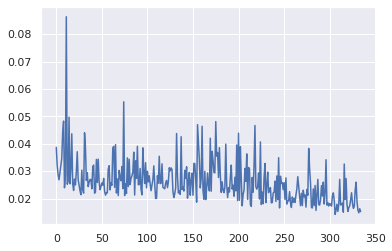

In [88]:
plt.plot(np.mean(np.asarray(validation_losses_mc), axis=0))
plt.show()